<a href="https://colab.research.google.com/github/jannat0718/Face-Mask-Detection/blob/main/Facemask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
#import glob
#import os


##Directory Setup

In [ ]:
Working_dir='/content/drive/MyDrive/Colab Notebooks/Mask detection/'
Data_directory='/content/drive/MyDrive/Kaggle_dataset/Mask_dataset/Face Mask Detection Dataset.zip'## dataset uploaded here

##Unzip dataset

In [ ]:
from zipfile import ZipFile
file=Data_directory
with ZipFile(file,'r') as zip:
  zip.printdir()
  print('processing...........')
  zip.extractall(Working_dir)
  print("Process completed!")

File Name                                             Modified             Size
Face Mask Detection Dataset/                   2021-08-31 22:26:08            0
Face Mask Detection Dataset/dataset/           2020-07-09 20:42:14            0
Face Mask Detection Dataset/dataset/without_mask/ 2020-07-09 20:42:14            0
Face Mask Detection Dataset/dataset/without_mask/0.jpg 2020-07-09 20:42:14        21764
Face Mask Detection Dataset/dataset/without_mask/0_0_aidai_0014.jpg 2020-07-09 20:42:14         6318
Face Mask Detection Dataset/dataset/without_mask/0_0_aidai_0029.jpg 2020-07-09 20:42:14         7615
Face Mask Detection Dataset/dataset/without_mask/0_0_aidai_0043.jpg 2020-07-09 20:42:14         8266
Face Mask Detection Dataset/dataset/without_mask/0_0_aidai_0074.jpg 2020-07-09 20:42:14         5868
Face Mask Detection Dataset/dataset/without_mask/0_0_aidai_0084.jpg 2020-07-09 20:42:14         6299
Face Mask Detection Dataset/dataset/without_mask/0_0_aidai_0136.jpg 2020-07-09 20:42

##Hyperparameter setting

In [ ]:
##Hyperparameter
Batch_size=64
learning_rate=1e-4
img_height=224
img_width=224
Num_epoch=10

##ImageDatafenerator & flow_from_directory

In [ ]:
datagen=ImageDataGenerator(
    rescale=1/255,
    zoom_range=(0.95,0.95),
    data_format='channels_last',
    dtype=tf.float32,
    validation_split=0.1,
)

In [ ]:
train_generator=datagen.flow_from_directory(
  '/content/drive/MyDrive/Colab Notebooks/Mask detection/Face Mask Detection Dataset/dataset/',
  target_size=(img_height,img_width),
  batch_size=Batch_size,
  shuffle=True,
  class_mode='binary',
  subset='training',
  seed=123,
  #save_to_dir="/content/output",
  #save_format='png',
)

Found 3451 images belonging to 2 classes.


In [ ]:
validation_generator=datagen.flow_from_directory(
  '/content/drive/MyDrive/Colab Notebooks/Mask detection/Face Mask Detection Dataset/dataset/',
  target_size=(img_height,img_width),
  batch_size=Batch_size,
  shuffle=True,
  class_mode='binary',
  subset='validation',
  seed=123,
)

Found 382 images belonging to 2 classes.


##Classes

In [ ]:
[a,b]=test_generator.class_indices
classess=[a,b] 
print(classess[0])
print(classess[1])

NameError: ignored

##Visualize

In [ ]:
#Original image & label plotting function
def plot_sample(X,y,index):
  X = X[index]
  Y=int(y[index])
  #print(Y)
  label_title=("Label :"+ classess[Y])
  plt.xlabel(label_title)                
  plt.imshow(X)

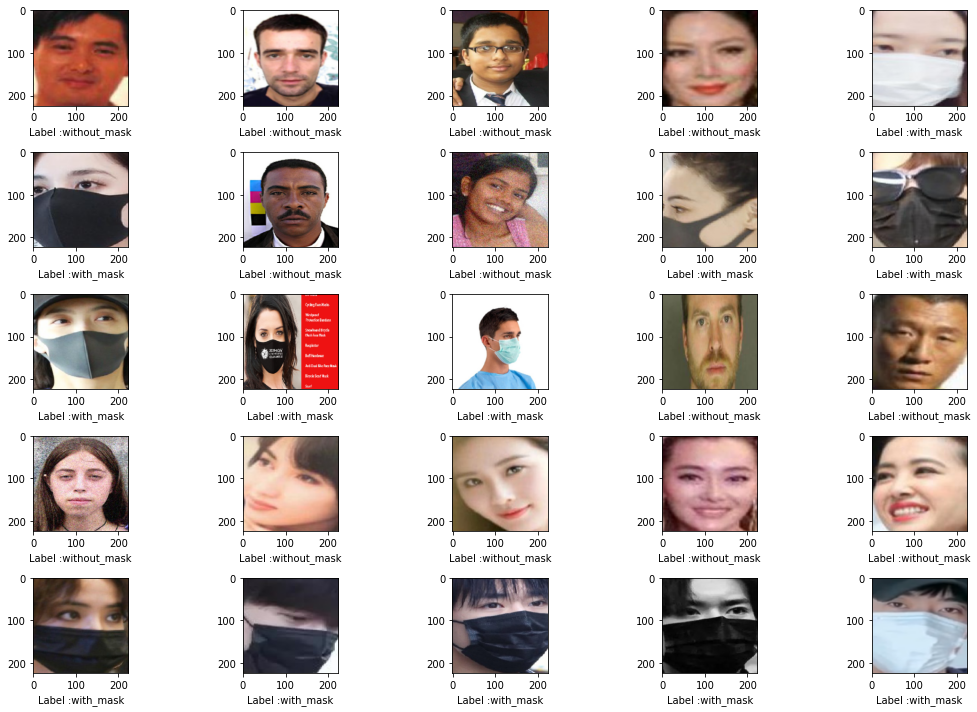

In [ ]:
#training figure
x_train,y_train=train_generator.next()

fig=plt.figure(figsize=(15,10)) 
axes=[] 
for index in range(25):
  axes.append( fig.add_subplot(5,5, index+1) )
  plot_sample(x_train,y_train,index)
fig.tight_layout()    
plt.show()

##Create model & Save the original before compile

In [ ]:
mobile_net=MobileNetV2()
mobile_net.summary()

In [ ]:
keras.utils.plot_model(mobile_net,'MobiletV2.png',show_shapes=True)

In [ ]:
mobile_net.trainnable=False

In [ ]:
base_input=mobile_net.layers[0].input
#base_input=tf.keras.applications.mobilenet.preprocess_input(base_input)
base_output=mobile_net.layers[-2].output
Flatten=layers.Flatten()(base_output)
Dense1=layers.Dense(128)(Flatten)
final_output=layers.Dense(2)(Dense1)
New_model=keras.Model(inputs=base_input,outputs=final_output)

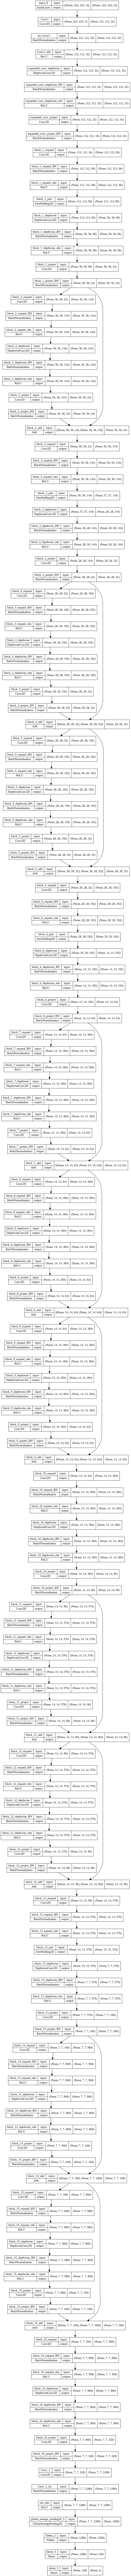

In [ ]:
keras.utils.plot_model(New_model,'New_MobiletV2.png',show_shapes=True)

In [ ]:
#save the model before compile
New_model.save(Working_dir+'mobile_net_before_compiling.h5')

##Set earlystopping,csvlogger,checkpoint

In [ ]:
#earlystopping
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,verbose=1)

In [ ]:
 #CSVlogger
log_csv=keras.callbacks.CSVLogger(Working_dir+'my log.csv',separator='.',append=False)

In [ ]:
#save callbacks
save_callback=keras.callbacks.ModelCheckpoint(
    filepath=Working_dir+'Checkpoint/',
    save_weights=True,
    monitor='val_accuracy',
    save_best_only=True,
)

##Compile the model

In [ ]:
#Model compile
New_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
steps_per_epochs=round((train_generator.samples)/Batch_size)
validation_steps=round((validation_generator.samples)/Batch_size)
steps_per_epochs,validation_steps

(54, 6)

In [ ]:
#Using model.fit
history=New_model.fit(train_generator,
                        epochs=3,
                        steps_per_epoch=steps_per_epochs,
                        verbose=1,
                        validation_data=validation_generator,
                        validation_steps=validation_steps,
                        callbacks=[save_callback,early_stop,log_csv])

Epoch 1/3
 1/54 [..............................] - ETA: 18:31 - loss: 0.0099 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


54/54 [==============================] - 785s 14s/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 0.4204 - val_accuracy: 0.9188
Epoch 2/3
13/54 [======>.......................] - ETA: 8:59 - loss: 0.0044 - accuracy: 0.9976

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


54/54 [==============================] - 753s 14s/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.1936 - val_accuracy: 0.9555
Epoch 3/3
15/54 [=======>......................] - ETA: 8:35 - loss: 5.9723e-04 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


54/54 [==============================] - 728s 13s/step - loss: 5.7186e-04 - accuracy: 1.0000 - val_loss: 0.2226 - val_accuracy: 0.9555


In [ ]:
history.history

{'accuracy': [0.9617502093315125],
 'loss': [0.09718243032693863],
 'val_accuracy': [0.9083769917488098],
 'val_loss': [0.40472444891929626]}

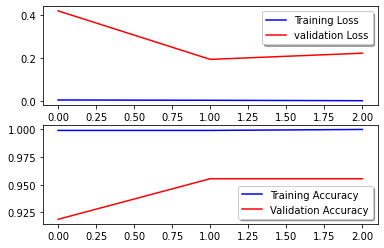

In [ ]:
# Show Loss and Accuracy Plots
fig, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation Loss",axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

#Model testing on Image 

##Download  dataset using bing

In [ ]:
!pip install bing-image-downloader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bing_image_downloader import downloader
downloader.download('people wearing mask', limit=50,  output_dir=Working_dir+'Test_data/', 
adult_filter_off=True, force_replace=False, timeout=60)


NameError: ignored

##Prepare test dataset

In [ ]:
test_datagen=datagen=ImageDataGenerator(
    rescale=1/255,
    data_format='channels_last',
    dtype=tf.float32,
    )

In [ ]:
test_generator=test_datagen.flow_from_directory(
  '/content/drive/MyDrive/Colab Notebooks/Mask detection/Test_data/',
  target_size=(img_height,img_width),
  batch_size=Batch_size,
  shuffle=True,
  class_mode='binary',
  seed=123,
)

Found 106 images belonging to 2 classes.


##Load saved model and weights

In [ ]:
#Load model
original_model=keras.models.load_model(Working_dir+'mobile_net_before_compiling.h5')
##Load weights
original_model.load_weights(Working_dir+'Checkpoint/')

##Compile

In [ ]:
#Model compile
original_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
original_model.save(Working_dir+'mask_detector_model.h5')

#Saved the model with trainning weight & optimizers

##Evaluate model performance

In [ ]:
#Evaluate model
results=original_model.evaluate(test_generator,verbose=2)
print("Test loss, Test acc:", results)

2/2 - 3s - loss: 1.1545 - accuracy: 0.7453 - 3s/epoch - 1s/step
Test loss, Test acc: [1.1544811725616455, 0.7452830076217651]


##Predict result

In [ ]:
x_test,y_test=test_generator.next()
#Claculated the prediction probabilities
Y_prediction=original_model.predict(x_test)
#Calculate the maximum value for probabilities 
Y_classes=[np.argmax(element) for element in Y_prediction]
print('Original label:',y_test)
print('Predicted label:',Y_classes)

Original label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
Predicted label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
#Define a prediction plot model
def prediction_plot(X,Y,predicted_label,index):
  X= X[index]
  Y=int(Y[index])
  label_title1=(classess[Y]+' , '+classess[predicted_label[index]])
  plt.xlabel(label_title1)                
  plt.imshow(X)

Enter your Image number [0-32]: 1


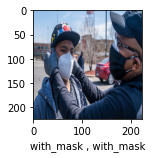

In [ ]:
#Check the single image result
Put_number = int(input("Enter your Image number [0-32]: "))
#print('Original Classes :',classes[(Y_test.reshape(-1,))[Put_number]])
#print('Predicted Classes: ',classes[Y_classes[Put_number]])
fig=plt.figure(figsize=(15,2)) 
prediction_plot(x_test,y_test,Y_classes,Put_number)
plt.show()

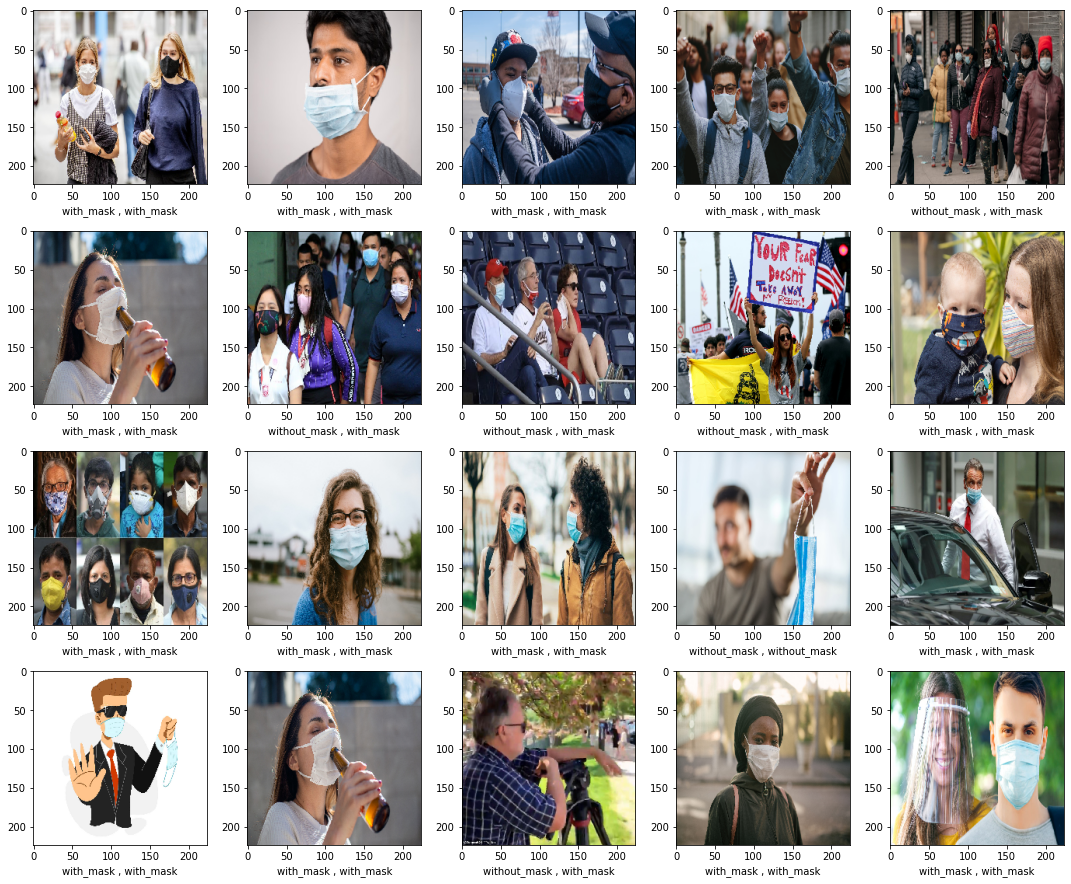

In [ ]:
#Visualize the 1st 25 test data label prediction
fig=plt.figure(figsize=(15,15)) 
axes=[] 
for index in range(20):
  axes.append( fig.add_subplot(5,5, index+1) )
  prediction_plot(x_test,y_test,Y_classes,index)
fig.tight_layout()    
plt.show()

#Live cam testing

##Import

##Load the saved model & weights & compile it

In [ ]:
#Load model
maskNet=keras.models.load_model(Working_dir+'mobile_net_before_compiling.h5')
##Load weights
maskNet.load_weights(Working_dir+'Checkpoint/')
#Model compile
maskNet.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

##Face detection model

In [ ]:
##Face detection model ## Downloaded from opencv github/data/harr_cascade_model
faceCascade=cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/Mask detection/haarcascade_frontalface_alt.xml')

In [ ]:
def face_mask_detector(frame):
  # frame = cv2.imread(fileName)
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(gray,
                                        scaleFactor=1.1,
                                        minNeighbors=5,
                                        minSize=(60, 60),
                                        flags=cv2.CASCADE_SCALE_IMAGE)
  faces_list=[]
  preds=[]
  for (x, y, w, h) in faces:
      face_frame = frame[y:y+h,x:x+w]
      face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
      face_frame = cv2.resize(face_frame, (224, 224))
      face_frame = img_to_array(face_frame)
      face_frame = np.expand_dims(face_frame, axis=0)
      face_frame =  preprocess_input(face_frame)
      faces_list.append(face_frame)
      if len(faces_list)>0:
          preds = maskNet.predict(faces_list)
      for pred in preds:
          (mask, withoutMask) = pred
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
      cv2.putText(frame, label, (x, y- 10),
                  cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

      cv2.rectangle(frame, (x, y), (x + w, y + h),color, 3)
  # cv2_imshow(frame)
  return frame

In [ ]:
input_image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Mask detection/Test_data/with_mask/Image_10.jpg')
output = face_mask_detector(input_image)
cv2_imshow(output)

##Face detection using webcam

In [ ]:
##Import
from imutils.video import VideoStream
import imutils
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab.patches import cv2_imshow
from google.colab.output import eval_js
from IPython.display import display, Javascript, Image
from base64 import b64decode, b64encode


In [ ]:
#load cascade classifier training file for haarcascade
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/Mask detection/haarcascade_frontalface_alt.xml')

In [ ]:
haar_face_cascade

<CascadeClassifier 0x7efc26cdf9f0>

In [ ]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
frame_height, frame_width= 480,640
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  output = face_mask_detector(frame)
  out.write(output)
out.release()
print("Done processing video")


Processing Video...
Done processing video


In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
   # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>